# PROJECT LUNG DISEASES

## REQUIREMENT

In [10]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tensorflow.keras.layers import TimeDistributed, Bidirectional, LSTM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG19, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score

## DATA PREP

### Import Dataset

In [2]:
! pip install -q kaggle
from google.colab import files
#upload kaggle.json API akun pribadi
files.upload()
# make directory for save the dataset
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
# Import dataset from kaggle to colab
! kaggle datasets download -d anjay007/penyakit-paru-paru-5-kelas

Saving kaggle.json to kaggle.json
 95% 267M/280M [00:02<00:00, 134MB/s]
100% 280M/280M [00:03<00:00, 97.2MB/s]


### Unzip dataset

In [3]:
! unzip  /content/penyakit-paru-paru-5-kelas.zip -d lung_disease/
#menghapus zip file dataset
!rm -r /content/penyakit-paru-paru-5-kelas.zip
#menghapus zip file dataset
!rm -r /content/kaggle.json

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: lung_disease/train_dir/bacterial_pneumonia/person26_bacteria_132.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person26_bacteria_133.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person27_bacteria_135.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person27_bacteria_136.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person27_bacteria_137.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person29_bacteria_144.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person2_bacteria_3.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_147.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_148.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_149.jpeg  
  inflating: lung_disease/train_dir/bacterial_pneumonia/person30_bacteria_150.jpeg  
  inflati

### Initiation Directory

In [4]:
#Path dataset
BASE_DIR = '/content/lung_disease/Lung Disease Dataset'

#Path train, test, dan validation
train = '/content/lung_disease/train_dir'
val = '/content/lung_disease/test_dir'

### Datagenerator

In [5]:
# Membuat objek ImageDataGenerator untuk augmentasi data pada set pelatihan
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Rescale nilai piksel ke rentang [0, 1]
    zoom_range=0.2 #,            # Memperbesar gambar hingga 20%
    #fill_mode='nearest'        # Mengisi piksel yang kosong dengan piksel terdekat
)

# Membuat objek ImageDataGenerator untuk preprocessing pada set pengujian dan validasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Menggunakan objek ImageDataGenerator untuk memuat data gambar dari direktori dan melakukan augmentasi
train_generator = train_datagen.flow_from_directory(
    train,
    target_size=(224, 224),
    class_mode='categorical',  # Mode kelas untuk klasifikasi banyak kelas
    batch_size = 4
)

val_generator = test_val_datagen.flow_from_directory(
    val,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size = 4
)


Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


## TRAINNING W RESNET50

### Load pretrined CNN

In [6]:
# Memuat model ResNet50 tanpa layer teratas (top layer)
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in resnet_model.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


### Project Model

In [11]:
#Membuat model
model_resnet = Sequential()
model_resnet.add(resnet_model)
model_resnet.add(TimeDistributed(Flatten()))
model_resnet.add(Bidirectional(LSTM(32, return_sequences=True)))
model_resnet.add(Bidirectional(LSTM(64, return_sequences=True)))
model_resnet.add(Flatten())
model_resnet.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_resnet.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 time_distributed (TimeDist  (None, 7, 14336)          0         
 ributed)                                                        
                                                                 
 bidirectional_1 (Bidirecti  (None, 7, 64)             3678464   
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 7, 128)            66048     
 onal)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 896)               0         
                                                      

In [12]:
# Compile model
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history = model_resnet.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
1520/1520 [==============================] - 146s 88ms/step - loss: 1.5931 - acc: 0.2461 - val_loss: 1.5118 - val_acc: 0.2576
Epoch 2/30
1520/1520 [==============================] - 113s 74ms/step - loss: 1.3286 - acc: 0.3979 - val_loss: 1.0481 - val_acc: 0.5743
Epoch 3/30
1520/1520 [==============================] - 117s 77ms/step - loss: 1.1860 - acc: 0.4638 - val_loss: 0.9719 - val_acc: 0.5794
Epoch 4/30
1520/1520 [==============================] - 113s 74ms/step - loss: 1.1418 - acc: 0.4934 - val_loss: 0.9874 - val_acc: 0.5692
Epoch 5/30
1520/1520 [==============================] - 112s 73ms/step - loss: 1.0865 - acc: 0.5192 - val_loss: 0.9959 - val_acc: 0.5876
Epoch 6/30
1520/1520 [==============================] - 117s 77ms/step - loss: 1.0695 - acc: 0.5286 - val_loss: 1.0057 - val_acc: 0.5815
Epoch 7/30
1520/1520 [==============================] - 113s 74ms/step - loss: 1.0392 - acc: 0.5395 - val_loss: 0.9012 - val_acc: 0.5845
Epoch 8/30
1520/1520 [===================

In [ ]:
model_resnet.save("resnet_model.h5")
with open('history_resnet.txt', mode='w') as file:
    file.write(str(history.history['acc'])+'/n'+str(history.history['loss']))
    file.close()

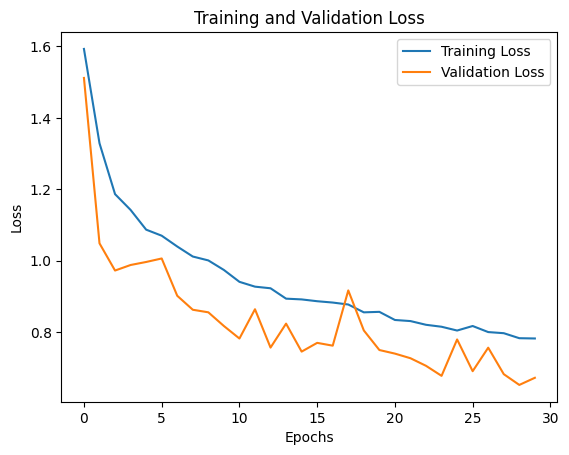

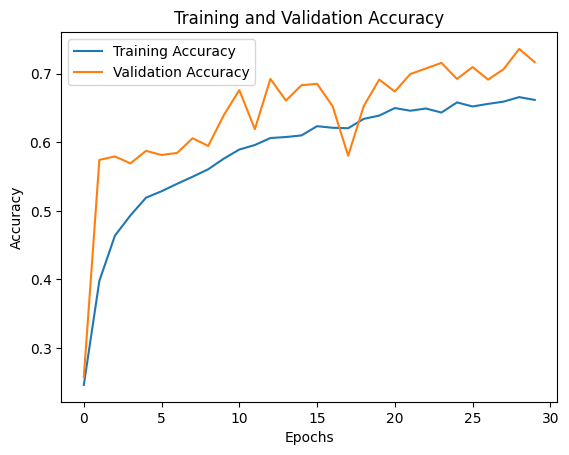

In [13]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
results = model_resnet.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

246/246 [==============================] - 7s 27ms/step - loss: 0.6712 - acc: 0.7169
Loss: 0.6712474822998047
Accuracy: 0.7169042825698853


In [15]:
train_predictions = model_resnet.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



1520/1520 [==============================] - 100s 64ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.19588   0.14016   0.16340      1220
            covid19    0.22255   0.18423   0.20158      1243
             normal    0.18080   0.14332   0.15989      1235
       tuberculosis    0.18765   0.26752   0.22058      1170
    viral_pneumonia    0.20509   0.25908   0.22895      1212

           accuracy                        0.19803      6080
          macro avg    0.19839   0.19886   0.19488      6080
       weighted avg    0.19852   0.19803   0.19456      6080



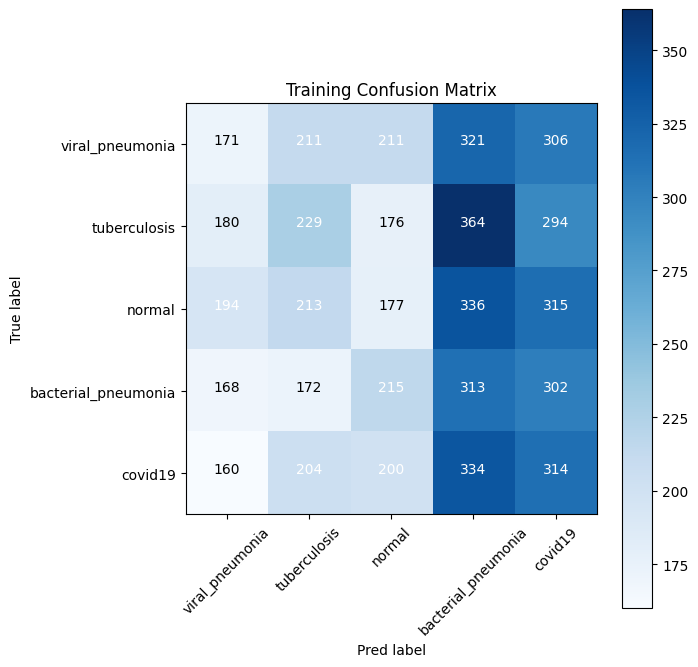

In [16]:
inp = '/content/lung_disease'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W VGG19


### Load Pretrained CNN

In [17]:
VGG19_model =VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in VGG19_model.layers:
    layer.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


### Our Model

In [18]:
#Membuat model
model_VGG19 = Sequential()
model_VGG19.add(VGG19_model)
model_VGG19.add(TimeDistributed(Flatten()))
model_VGG19.add(Bidirectional(LSTM(32, return_sequences=True)))
model_VGG19.add(Bidirectional(LSTM(64, return_sequences=True)))
model_VGG19.add(Flatten())
model_VGG19.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_VGG19.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 time_distributed_1 (TimeDi  (None, 7, 3584)           0         
 stributed)                                                      
                                                                 
 bidirectional_3 (Bidirecti  (None, 7, 64)             925952    
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 7, 128)            66048     
 onal)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 896)               0         
                                                      

In [19]:
# Compile model
model_VGG19.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_VGG19 = model_VGG19.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
1520/1520 [==============================] - 123s 75ms/step - loss: 0.8718 - acc: 0.6286 - val_loss: 0.5835 - val_acc: 0.7464
Epoch 2/30
1520/1520 [==============================] - 112s 74ms/step - loss: 0.5878 - acc: 0.7599 - val_loss: 0.4864 - val_acc: 0.8045
Epoch 3/30
1520/1520 [==============================] - 112s 74ms/step - loss: 0.5161 - acc: 0.7821 - val_loss: 0.6580 - val_acc: 0.7189
Epoch 4/30
1520/1520 [==============================] - 112s 73ms/step - loss: 0.4757 - acc: 0.8013 - val_loss: 0.4113 - val_acc: 0.8310
Epoch 5/30
1520/1520 [==============================] - 112s 74ms/step - loss: 0.4487 - acc: 0.8140 - val_loss: 0.4622 - val_acc: 0.7902
Epoch 6/30
1520/1520 [==============================] - 112s 73ms/step - loss: 0.4220 - acc: 0.8237 - val_loss: 0.3439 - val_acc: 0.8605
Epoch 7/30
1520/1520 [==============================] - 111s 73ms/step - loss: 0.3793 - acc: 0.8461 - val_loss: 0.4847 - val_acc: 0.8086
Epoch 8/30
1520/1520 [===================

In [ ]:
model_VGG19.save("VGG19_model_skenario1.h5")
with open('history_VGG19.txt', mode='w') as file:
    file.write(str(history_VGG19.history['acc'])+'/n'+str(history_VGG19.history['loss']))
    file.close()

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


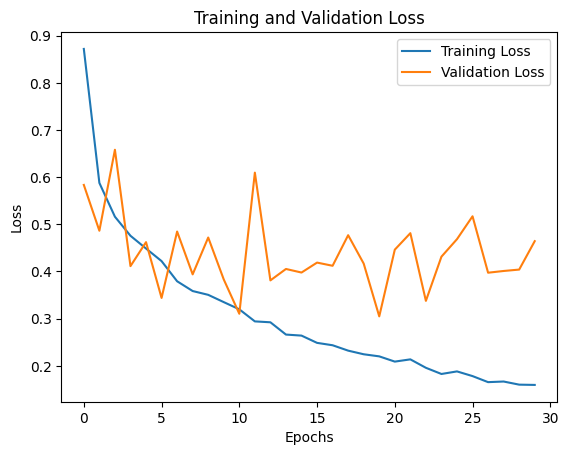

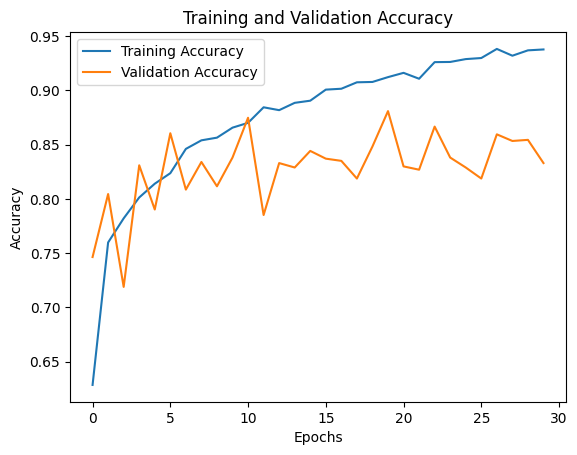

In [20]:
# Plot loss
plt.plot(history_VGG19.history['loss'], label='Training Loss')
plt.plot(history_VGG19.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_VGG19.history['acc'], label='Training Accuracy')
plt.plot(history_VGG19.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
results = model_VGG19.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

246/246 [==============================] - 10s 42ms/step - loss: 0.4643 - acc: 0.8330
Loss: 0.46431466937065125
Accuracy: 0.8329938650131226


In [23]:
train_predictions = model_VGG19.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



1520/1520 [==============================] - 103s 67ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.21014   0.21066   0.21040      1220
            covid19    0.21673   0.23974   0.22765      1243
             normal    0.20175   0.18623   0.19368      1235
       tuberculosis    0.19023   0.18632   0.18826      1170
    viral_pneumonia    0.19482   0.19224   0.19352      1212

           accuracy                        0.20329      6080
          macro avg    0.20273   0.20304   0.20270      6080
       weighted avg    0.20290   0.20329   0.20291      6080



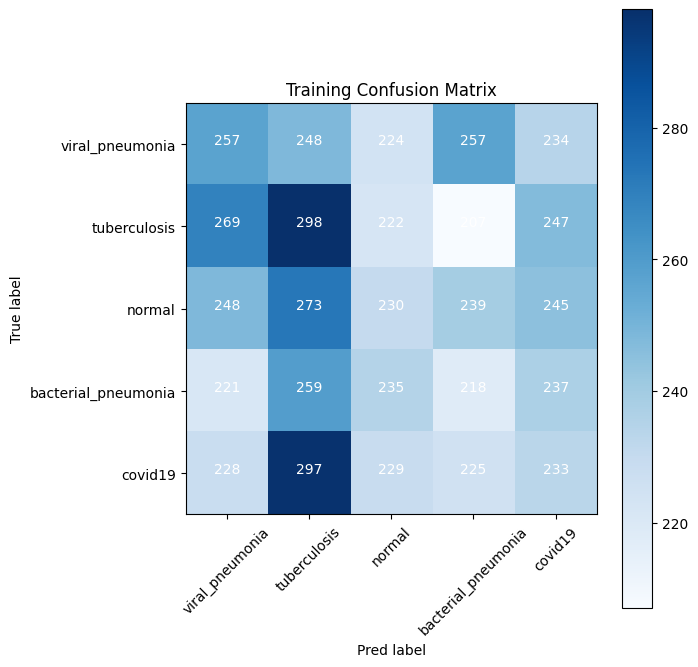

In [24]:
inp = '/content/lung_disease'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## TRAINNING W InceptionV3


### Load Pretrained CNN

In [25]:
InceptionV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in InceptionV3_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


### Our Model

In [26]:
#Membuat model
model_InceptionV3 = Sequential()
model_InceptionV3.add(InceptionV3_model)
model_InceptionV3.add(TimeDistributed(Flatten()))
model_InceptionV3.add(Bidirectional(LSTM(32, return_sequences=True)))
model_InceptionV3.add(Bidirectional(LSTM(64, return_sequences=True)))
model_InceptionV3.add(Flatten())
model_InceptionV3.add(Dense(train_generator.num_classes, activation='softmax'))

print(model_InceptionV3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 time_distributed_2 (TimeDi  (None, 5, 10240)          0         
 stributed)                                                      
                                                                 
 bidirectional_5 (Bidirecti  (None, 5, 64)             2629888   
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 5, 128)            66048     
 onal)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 640)               0         
                                                      

In [27]:
# Compile model
model_InceptionV3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['acc'])

# Train model
history_InceptionV3 = model_InceptionV3.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator
)

Epoch 1/30
1520/1520 [==============================] - 133s 79ms/step - loss: 0.7802 - acc: 0.6717 - val_loss: 0.6184 - val_acc: 0.7393
Epoch 2/30
1520/1520 [==============================] - 121s 80ms/step - loss: 0.5612 - acc: 0.7655 - val_loss: 0.5283 - val_acc: 0.7760
Epoch 3/30
1520/1520 [==============================] - 117s 77ms/step - loss: 0.4978 - acc: 0.7987 - val_loss: 0.5053 - val_acc: 0.7851
Epoch 4/30
1520/1520 [==============================] - 116s 76ms/step - loss: 0.4520 - acc: 0.8173 - val_loss: 0.4505 - val_acc: 0.8055
Epoch 5/30
1520/1520 [==============================] - 117s 77ms/step - loss: 0.4048 - acc: 0.8370 - val_loss: 0.4797 - val_acc: 0.8055
Epoch 6/30
1520/1520 [==============================] - 117s 77ms/step - loss: 0.3825 - acc: 0.8446 - val_loss: 0.4559 - val_acc: 0.7994
Epoch 7/30
1520/1520 [==============================] - 117s 77ms/step - loss: 0.3566 - acc: 0.8581 - val_loss: 0.4859 - val_acc: 0.8045
Epoch 8/30
1520/1520 [===================

In [ ]:
model_InceptionV3.save("InceptionV3_model.h5")
with open('history_InceptionV3.txt', mode='w') as file:
    file.write(str(history_InceptionV3.history['acc'])+'/n'+str(history_InceptionV3.history['loss']))
    file.close()

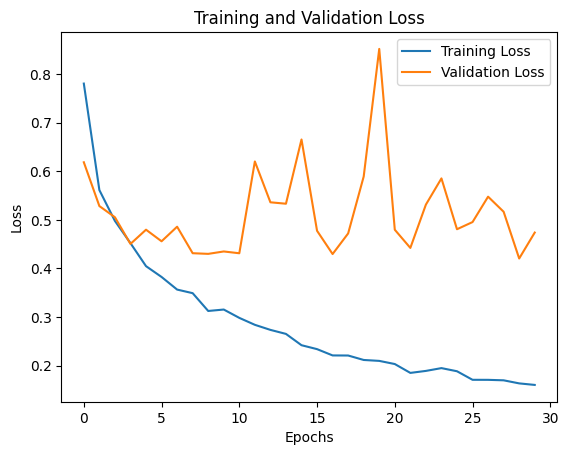

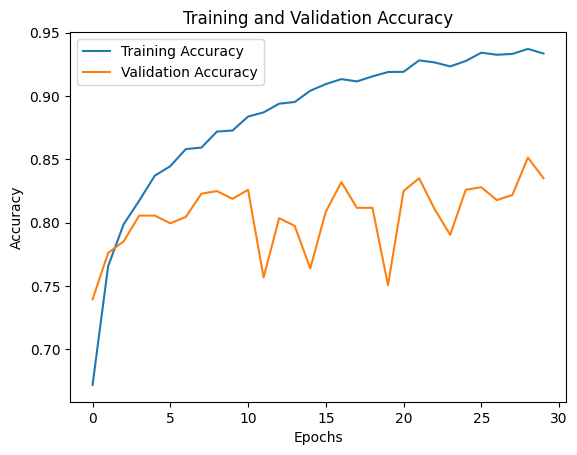

In [28]:
# Plot loss
plt.plot(history_InceptionV3.history['loss'], label='Training Loss')
plt.plot(history_InceptionV3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_InceptionV3.history['acc'], label='Training Accuracy')
plt.plot(history_InceptionV3.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
results = model_InceptionV3.evaluate(val_generator)

print("Loss:", results[0])
print("Accuracy:", results[1])

246/246 [==============================] - 6s 24ms/step - loss: 0.4738 - acc: 0.8350
Loss: 0.47384992241859436
Accuracy: 0.8350305557250977


In [32]:
train_predictions = model_InceptionV3.predict(train_generator, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_generator.classes

train_class_report = classification_report(train_true_labels,
                                          train_predicted_labels, target_names=train_generator.class_indices,
                                          digits=5)
print("\nTraining classification report:\n", train_class_report)



1520/1520 [==============================] - 111s 65ms/step

Training classification report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.20501   0.18115   0.19234      1220
            covid19    0.19603   0.19067   0.19331      1243
             normal    0.20451   0.21296   0.20865      1235
       tuberculosis    0.19003   0.18889   0.18946      1170
    viral_pneumonia    0.18899   0.20957   0.19875      1212

           accuracy                        0.19671      6080
          macro avg    0.19691   0.19665   0.19650      6080
       weighted avg    0.19700   0.19671   0.19657      6080



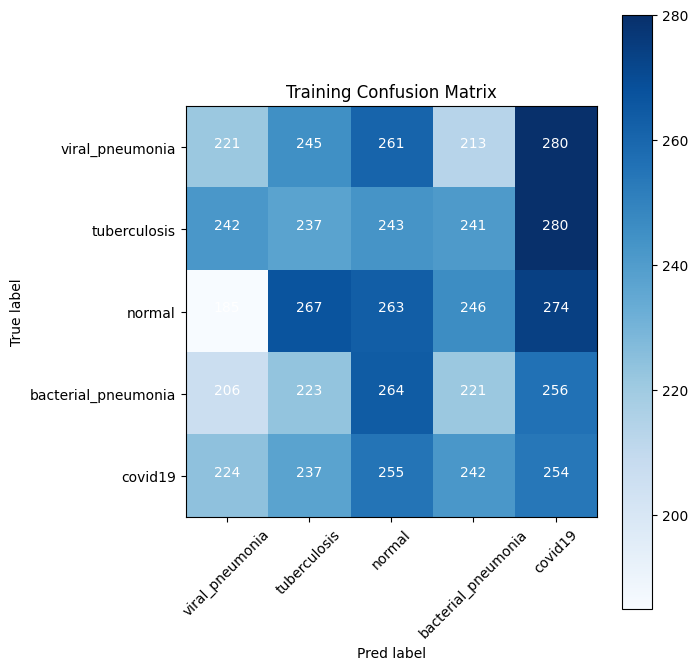

In [33]:
inp = '/content/lung_disease'
classes = []
filename = inp
for sub_folder in os.listdir(os.path.join(filename, 'train_dir')):
    classes.append(sub_folder)
# print(classes)
classname_label = classes
train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(7, 7))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()